## Imports and General Configurations

This section sets up the environment by importing necessary libraries, defining configurations, and setting random seeds for reproducibility.

### 1. **Imports**

- **External Frameworks**:  
  Essential libraries such as `numpy`, `pandas`, `matplotlib`, and PyTorch (`torch`, `torchvision`, etc.) are imported to handle data processing, visualization, and deep learning tasks.

- **Internal Code**:  
  Custom modules and functions from the project are imported, including models (`VAE`, `BYOL`, `Encoder`, `Generator`), and custom datasets (`SinDataset`).

### 2. **Configuration Class (`cfg`)**

Defines a configuration class `cfg` to centralize model parameters:

- **Dataset Parameters**:  
  Specifies the number of training and test samples, number of channels, sequence size, and feature sizes.
  
- **Training Parameters**:  
  Sets values for epochs, batch size, learning rate, weight decay, and intervals for printing and checkpoints.

- **Device Configuration**:  
  Checks for GPU availability and sets the computation device accordingly (`cuda` if available).

### 3. **Setting Random Seed**

To ensure reproducibility, a function `set_seed` is defined and used to set the seed for various libraries (`numpy`, `random`, `torch`). This helps maintain consistency across different runs of the experiment.


In [1]:
# External Frameworks
import os
import time

import math
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Internal Code
from data import SinDataset

from models import VAE
from models import BYOL
from models import Discriminator, Encoder, Generator
from models import ResNet18, ResNet50, ResNet101, ResNet152
from models import dtw_distance

from utils import hybrid_z_sampling, signal_change_z_sampling

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [116]:
class cfg:
    n_samples_train = 10000
    n_samples_test = 1000
    num_channels = 1

    epochs = 500
    epochs_byol = 100
    interval_print = 20
    model_checkpoint = 100

    batch_size = 32
    batch_size_byol = 64

    learning_rate = 0.0001
    weight_decay = 1e-5
    
    seq_size = 256
    interval_size = seq_size//2
    feature_size = 16 # 1:16 rate of "compression"
    z_size = 100

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f'running on device: {cfg.device}')

running on device: cuda


In [3]:
def set_seed(seed_number=42, loader=None):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed_number)
    np.random.seed(seed_number)
    random.seed(seed_number)
    try:
        loader.sampler.generator.manual_seed(seed_number)
    except AttributeError:
        pass

set_seed(42)

## Open Dataset

In this experiment, we use a **synthetic sinusoidal dataset**. The data is generated with the `SinDataset` class and loaded using PyTorch's `DataLoader`. The code below demonstrates the loading of data samples and visualizes the first sample pair, highlighting the `Anchor` and `Positive` sequences.

- **Dataset Initialization**: The `SinDataset` is created with a specified number of samples and sequence size.
- **Dataloader**: The data is then wrapped in a `DataLoader` for efficient batching and shuffling.
- **Visualization**: The code iterates through the dataloader, plotting the first pair of sequences: the `Anchor` (blue) and `Positive` (orange), illustrating the relationship between the two.

In [4]:
dataset = SinDataset(n_samples=cfg.n_samples_train, seq_size=cfg.seq_size)
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True)

  0%|          | 0/313 [00:00<?, ?it/s]

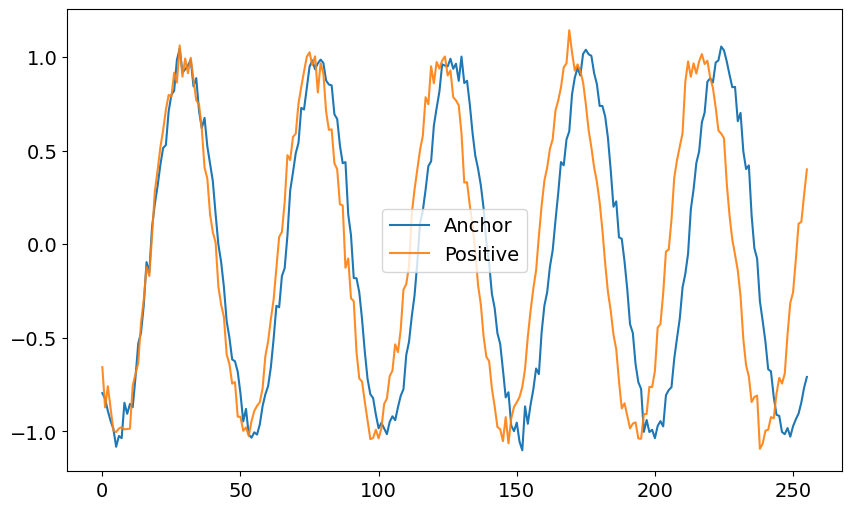

  0%|          | 1/313 [00:00<00:59,  5.23it/s]


In [5]:
for i, (original_well, pair_well, b, name) in enumerate(tqdm(dataloader)):
    if i>0: break
        
    plt.figure(figsize=(10,6))
    
    plt.plot(np.arange(0, len(original_well[0])), original_well[0], alpha=1.0, label='Anchor')
    plt.plot(np.arange(0, len(pair_well[0])), pair_well[0], alpha=0.9, label='Positive')
    
    plt.legend(prop={'size': 14})
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    plt.show()
    

# Models

In this study, we explore and evaluate various models to address the problem, each with its unique approach and underlying technique. Below is an overview of the models used:

- **WellGT (OURS)**:  
  Our proposed model, WellGT, is designed specifically for well log data analysis. It uses triplet loss and a generative technique to sampl negative.

- **Bootstrap Your Own Latent (BYOL)**:  
  BYOL is a self-supervised learning framework that generates latent representations by predicting one view of an image from another view. This method helps capture essential features without needing labeled data, making it highly suitable for exploratory data analysis.

- **Variational Autoencoder (VAE)**:  
  A VAE is a generative model that learns to encode input data into a latent space and decode it back to reconstruct the original input. VAEs are particularly useful in scenarios where understanding the underlying structure of the data distribution is crucial.

- **Dynamic Time Warping (DTW)**:  
  DTW is a classic technique used to measure similarity between two time series, allowing for non-linear alignments between sequences. It is particularly effective in comparing sequences of different lengths or with variable speeds.

### **Excluded Model: Triplet Romanenkova**

- **Triplet Romanenkova** is **NOT** used in this study because its method of triplet loss-based training does not directly map to the characteristics of our problem. This approach's way of defining anchor, positive, and negative samples does not apply to this problem.

### **Training Process**

Each model must be trained specifically for the task at hand to ensure optimal performance. The training code for each model is provided in the cells below, detailing the steps taken to fine-tune and evaluate the models on the dataset.

## BYOL

In [118]:
dataloader_BYOL = DataLoader(dataset, batch_size=cfg.batch_size_byol, shuffle=True)

backbone_byol = ResNet50(cfg.seq_size, cfg.num_channels).to(cfg.device)
byol = BYOL(backbone_byol,
            image_size = (cfg.num_channels, cfg.seq_size),
            hidden_layer = -2,
            projection_size = cfg.seq_size,
            projection_hidden_size = 4096,
            moving_average_decay = 0.99,
            use_momentum = True,
            sync_batchnorm = None)

opt_byol = torch.optim.Adam(byol.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)
scheduler_byol = torch.optim.lr_scheduler.StepLR(opt_byol, cfg.epochs_byol // 10, 0.8)

Epochs set to a **low** value because byol tend to overfit fast to this data

In [ ]:
for epoch in range(cfg.epochs_byol):

    tic = time.time()
    
    byol.train()
    byol.net.train()

    loss_byol_list = []

    for i, (positive1, positive2, b, name) in enumerate(dataloader_BYOL):
        
        batch_size = positive1.shape[0]

        positive1 = positive1.unsqueeze(-1).float().to(cfg.device)
        positive1 = positive1.permute(0, 2, 1)
        
        positive2 = positive2.unsqueeze(-1).float().to(cfg.device)
        positive2 = positive2.permute(0, 2, 1)

        #################
        # Updating BYOL #
        #################
        
        opt_byol.zero_grad()
        
        byol_loss = byol(positive1, positive2)

        byol_loss.backward()
        opt_byol.step()

        byol.update_moving_average()

        loss_byol_list.append(byol_loss.data.item())

    mean_loss_byol = np.mean(loss_byol_list)

    t = int(time.time() - tic)

    print(f'epoch: {epoch}/{cfg.epochs_byol} - loss BYOL: {mean_loss_byol:.4f} - {t // 60}m {t % 60}s', end='\r')

    scheduler_byol.step()

## VAE

In [8]:
vae = VAE(cfg.num_channels, cfg.num_channels, cfg.feature_size, cfg.seq_size).to(cfg.device)

opt_vae = torch.optim.Adam(vae.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)

scheduler_vae = torch.optim.lr_scheduler.StepLR(opt_vae, cfg.epochs // 10, 0.8)

In [9]:
original_sinusoidal_over_epochs = []
reconstructed_sinusoidal_over_epochs = []
epochs_plot = []

for epoch in range(cfg.epochs):

    tic = time.time()

    vae.train()

    loss_vae_list = []

    for i, (positive1, positive2, b, name) in enumerate(dataloader):
        
        batch_size = positive1.shape[0]

        positive1 = positive1.unsqueeze(-1).float().to(cfg.device)
        positive1 = positive1.permute(0, 2, 1)
        
        positive2 = positive2.unsqueeze(-1).float().to(cfg.device)
        positive2 = positive2.permute(0, 2, 1)

        ################
        # Updating VAE #
        ################

        # Clearing the gradients of D optimizer.
        opt_vae.zero_grad()

        # Forwarding data.
        reconstructed_sequence, mu, logvar = vae(positive1)

        # Computing loss for data.
        vae_loss = vae.loss_function(positive1, reconstructed_sequence, mu, logvar, M_N = 0.005)
        vae_loss_value = vae_loss['loss']
        vae_kl_loss = vae_loss['KLD']
        vae_error_loss = vae_loss['Reconstruction_Loss']

        # Computing backpropagation for VAE.
        vae_loss_value.backward()

        # Taking step in VAE optimizer.
        opt_vae.step()

        loss_vae_list.append(vae_loss_value.data.item())

    mean_loss_vae = np.mean(loss_vae_list)
    
    t = int(time.time() - tic)
    
    print(f'epoch: {epoch}/{cfg.epochs} - loss VAE: {mean_loss_vae:.4f} - {t // 60}m {t % 60}s', end='\r')

    scheduler_vae.step()

    if epoch % 50 == 0:
        with torch.no_grad():
            vae.eval()
            for i, (positive1, positive2, b, name) in list(enumerate(dataloader))[:1]:
                batch_size = positive1.shape[0]
                
                positive1 = positive1.unsqueeze(-1).float().to(cfg.device)
                positive1 = positive1.permute(0, 2, 1)

                reconstructed_sequence, mu, logvar = vae(positive1)
                
                positive1 = positive1.permute(0, 2, 1).cpu().detach().numpy()
                reconstructed_sequence = reconstructed_sequence.permute(0, 2, 1).cpu().detach().numpy()

                original_sinusoidal_over_epochs.append(positive1[0])
                reconstructed_sinusoidal_over_epochs.append(reconstructed_sequence[0])
                epochs_plot.append(epoch)

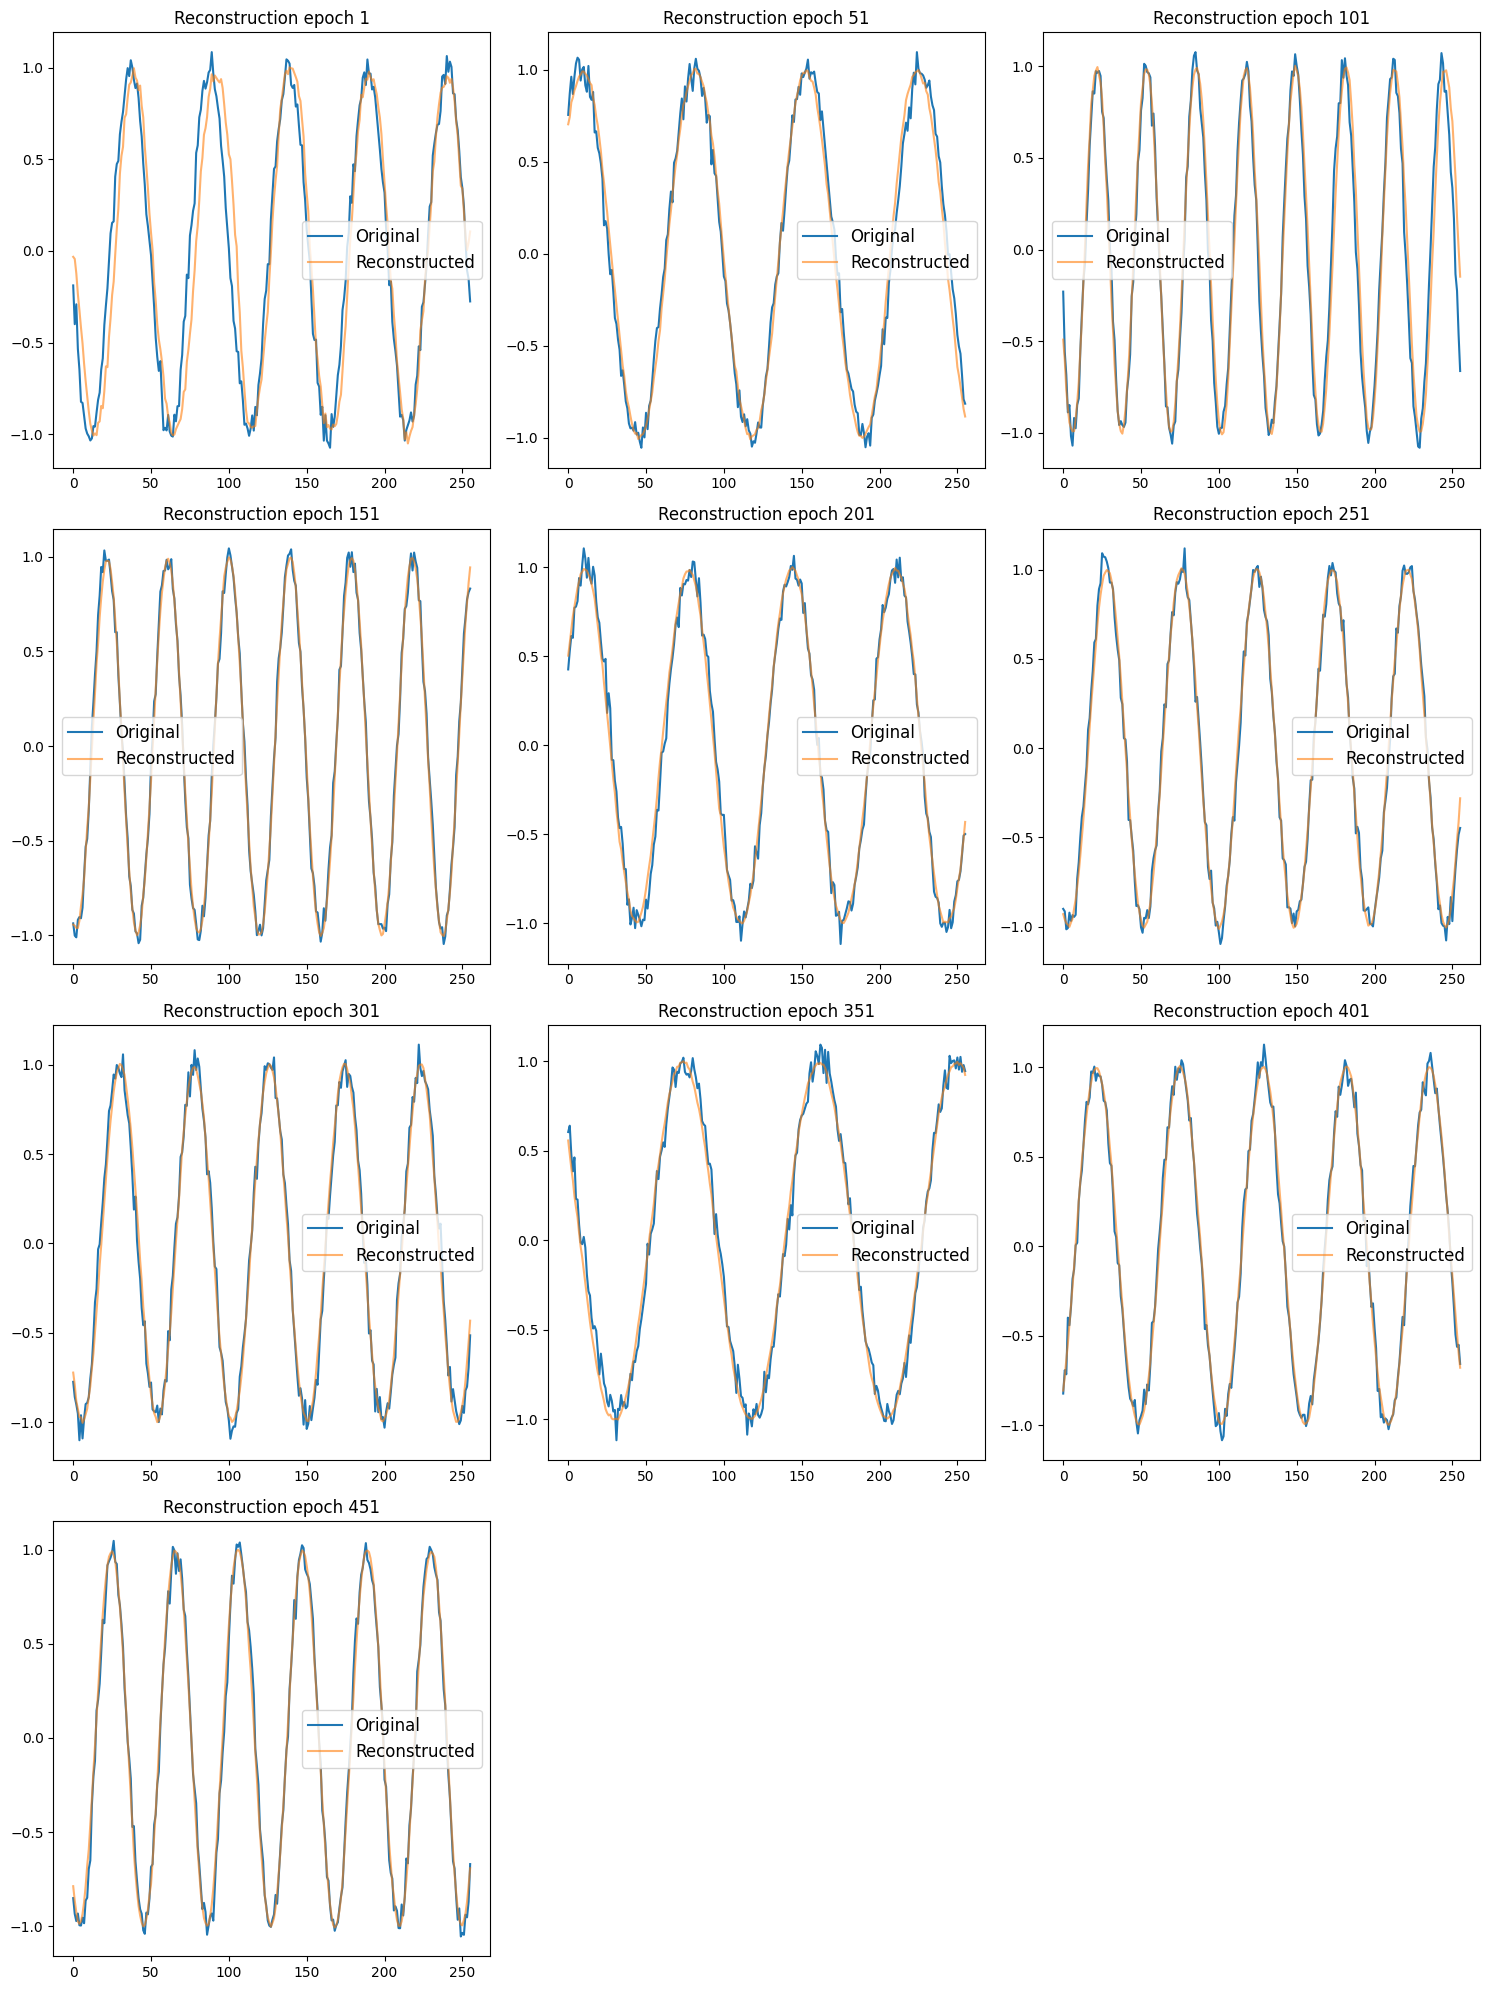

In [10]:
columns = 3
rows = math.ceil(len(original_sinusoidal_over_epochs) / columns)

fig, axs = plt.subplots(rows, columns, figsize=(15, 5*rows))
axs = axs.flatten()

for i in range(len(original_sinusoidal_over_epochs)):
    axs[i].plot(np.arange(0, len(original_sinusoidal_over_epochs[i])), original_sinusoidal_over_epochs[i][:,0], label='Original')
    axs[i].plot(np.arange(0, len(reconstructed_sinusoidal_over_epochs[i])), reconstructed_sinusoidal_over_epochs[i][:,0], label='Reconstructed', alpha=0.6)
    axs[i].set_title(f'Reconstruction epoch {epochs_plot[i]+1}')
    axs[i].legend(prop={'size': 12})

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])
    
plt.tight_layout()
plt.show()

## WellGT

In [13]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [40]:
# Models
net_G = Generator(cfg.z_size, cfg.num_channels).to(device=cfg.device)
net_G.main_module[19] = Identity()

net_D = Discriminator(cfg.num_channels, cfg.z_size).to(device=cfg.device)
net_E = Encoder(cfg.num_channels, cfg.z_size).to(device=cfg.device)

net_Sim = ResNet50(cfg.feature_size, cfg.num_channels).to(device=cfg.device)

# Losses
sim_loss = nn.TripletMarginLoss(margin=0.1, p=2, eps=1e-7, swap=True)
gan_loss = nn.BCELoss()

# Optimizers
opt_GE = torch.optim.Adam(list(net_G.parameters()) + list(net_E.parameters()), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)
opt_D = torch.optim.Adam(net_D.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)

opt_Sim = torch.optim.Adam(net_Sim.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)

# Learning Rate schedulers
scheduler_GE = torch.optim.lr_scheduler.StepLR(opt_GE, cfg.epochs // 10, 0.8)
scheduler_D = torch.optim.lr_scheduler.StepLR(opt_D, cfg.epochs // 10, 0.8)

scheduler_Sim = torch.optim.lr_scheduler.StepLR(opt_Sim, cfg.epochs // 10, 0.8)

In [41]:
original_sinusoidal_over_epochs = []
generated_sinusoidal_over_epochs = []
epochs_plot = []

for epoch in range(cfg.epochs):

    tic = time.time()

    net_D.train()
    net_G.train()
    net_E.train()
    net_Sim.train()
    
    loss_G_list = []
    loss_D_list = []
    loss_E_list = []
    loss_Sim_list = []
    
    for i, (positive1, positive2, b, name) in enumerate(dataloader):

        batch_size = positive1.shape[0]

        # Predefining ones and zeros for batches.
        ones_ = torch.ones(batch_size, 1).to(cfg.device)
        zeros_ = torch.zeros(batch_size, 1).to(cfg.device)
                
        positive1 = positive1.unsqueeze(-1).float().to(cfg.device)
        positive1 = positive1.permute(0, 2, 1)
        
        positive2 = positive2.unsqueeze(-1).float().to(cfg.device)
        positive2 = positive2.permute(0, 2, 1)

        ##################
        # Updating net_D #
        ##################

        z = torch.randn(size=(batch_size, cfg.z_size, 1), device=cfg.device)
        
        # Clearing the gradients of D optimizer.
        opt_D.zero_grad()

        real_encoded = net_E(positive1)

        # Forwarding real data.
        output_real = net_D(positive1, real_encoded.detach()) # Through D.

        # Computing loss for real data.
        D_real_loss = gan_loss(output_real, ones_)

        G_out = net_G(z) # Through G.
        output_fake = net_D(G_out.detach(), z) # Through D.

        # Computing loss for fake data.
        D_fake_loss = gan_loss(output_fake, zeros_)

        # Computing total loss for D.
        D_loss = (D_real_loss + D_fake_loss)/2

        # Computing backpropagation for D.
        D_loss.backward()

        # Taking step in D optimizer.
        opt_D.step()
        
        #####################
        # Updating G and E. #
        #####################
            
        # Clearing the gradients of GE optimizer.
        opt_GE.zero_grad()

        G_out = net_G(z) # Through G.
        real_encoded = net_E(positive1)

        output_fake = net_D(G_out, z) # Through D.
        output_real = net_D(positive1, real_encoded)

        # Computing loss for G and E.
        G_loss = gan_loss(output_fake, ones_)
        E_loss = gan_loss(output_real, zeros_)
        GE_loss = G_loss + E_loss

        # Computing backpropagation for G and E.
        GE_loss.backward()

        # Taking step in GE optimizer.
        opt_GE.step()

        ####################
        # Updating net_Sim #
        ####################
        
        # Clearing the gradients of D optimizer.
        opt_Sim.zero_grad()
        
        # Forwarding real data.
        output1_real, output2_real = net_Sim(positive1, positive2) # Through Sim.

        with torch.no_grad():
            z_encoded = net_E(positive1).detach()  # Ensure no gradients flow back
        # Creating random vector z.
        z = torch.randn(size=(batch_size, cfg.z_size, 1), device=cfg.device)
        z = hybrid_z_sampling(z, z_encoded, batch_size=batch_size, z_size=cfg.z_size, device=cfg.device)
        
        G_out = net_G(z) # Through G.
        output1_fake, output2_fake = net_Sim(positive1, G_out.detach()) # Through Sim.
        
        Sim_loss = sim_loss(output1_real, output2_real, output2_fake)

        # Computing backpropagation for D.
        Sim_loss.backward()

        # Taking step in D optimizer.
        opt_Sim.step()
        
        # Updating lists.
        loss_G_list.append(G_loss.data.item())
        loss_D_list.append(D_loss.data.item())
        loss_E_list.append(E_loss.data.item())
        loss_Sim_list.append(Sim_loss.data.item())

    # Printing training epoch loss.
    mean_loss_G = np.mean(loss_G_list)
    mean_loss_D = np.mean(loss_D_list)
    mean_loss_E = np.mean(loss_E_list)
    mean_loss_Sim = np.mean(loss_Sim_list)
    
    t = int(time.time() - tic)
    
    print(f'epoch: {epoch}/{cfg.epochs} - loss GANSim: {mean_loss_Sim:.4f} - {t // 60}m {t % 60}s', end='\r')
    
    # Taking step on scheduler.
    scheduler_GE.step()
    scheduler_D.step()
    scheduler_Sim.step()

    with torch.no_grad():
        if epoch % 50 == 0:
            net_G.eval()
            net_E.eval()
            #fig, ax = plt.subplots(3, cfg.num_channels, figsize=(20, 15))
            for i, (positive1, positive2, b, name) in list(enumerate(dataloader))[:1]:
        
                batch_size = positive1.shape[0]
                
                positive1 = positive1.unsqueeze(-1).float().to(cfg.device)
                positive1 = positive1.permute(0, 2, 1)
        
                z_encoded = net_E(positive1).detach()  # Ensure no gradients flow back
                # Creating random vector z.
                z = torch.randn(size=(batch_size, cfg.z_size, 1), device=cfg.device)
                z = hybrid_z_sampling(z, z_encoded, batch_size=batch_size, z_size=cfg.z_size, device=cfg.device)
    
                output_fake = net_G(z)
    
                positive1 = positive1.permute(0, 2, 1).cpu().detach().numpy()
                output_fake = output_fake.permute(0, 2, 1).cpu().detach().numpy()

                original_sinusoidal_over_epochs.append(positive1[0])
                generated_sinusoidal_over_epochs.append(output_fake[0])
                epochs_plot.append(epoch)

### Generator's Performance

The next cell shows how the generator perform in different epochs for the sinusoidal sequence generation.

The evolution of the generator is clear. It not only understands what makes a sinusoidal sequence, but it also models its latent space in an organized way so that the generated sequences spatially distant are also distant in frequency.

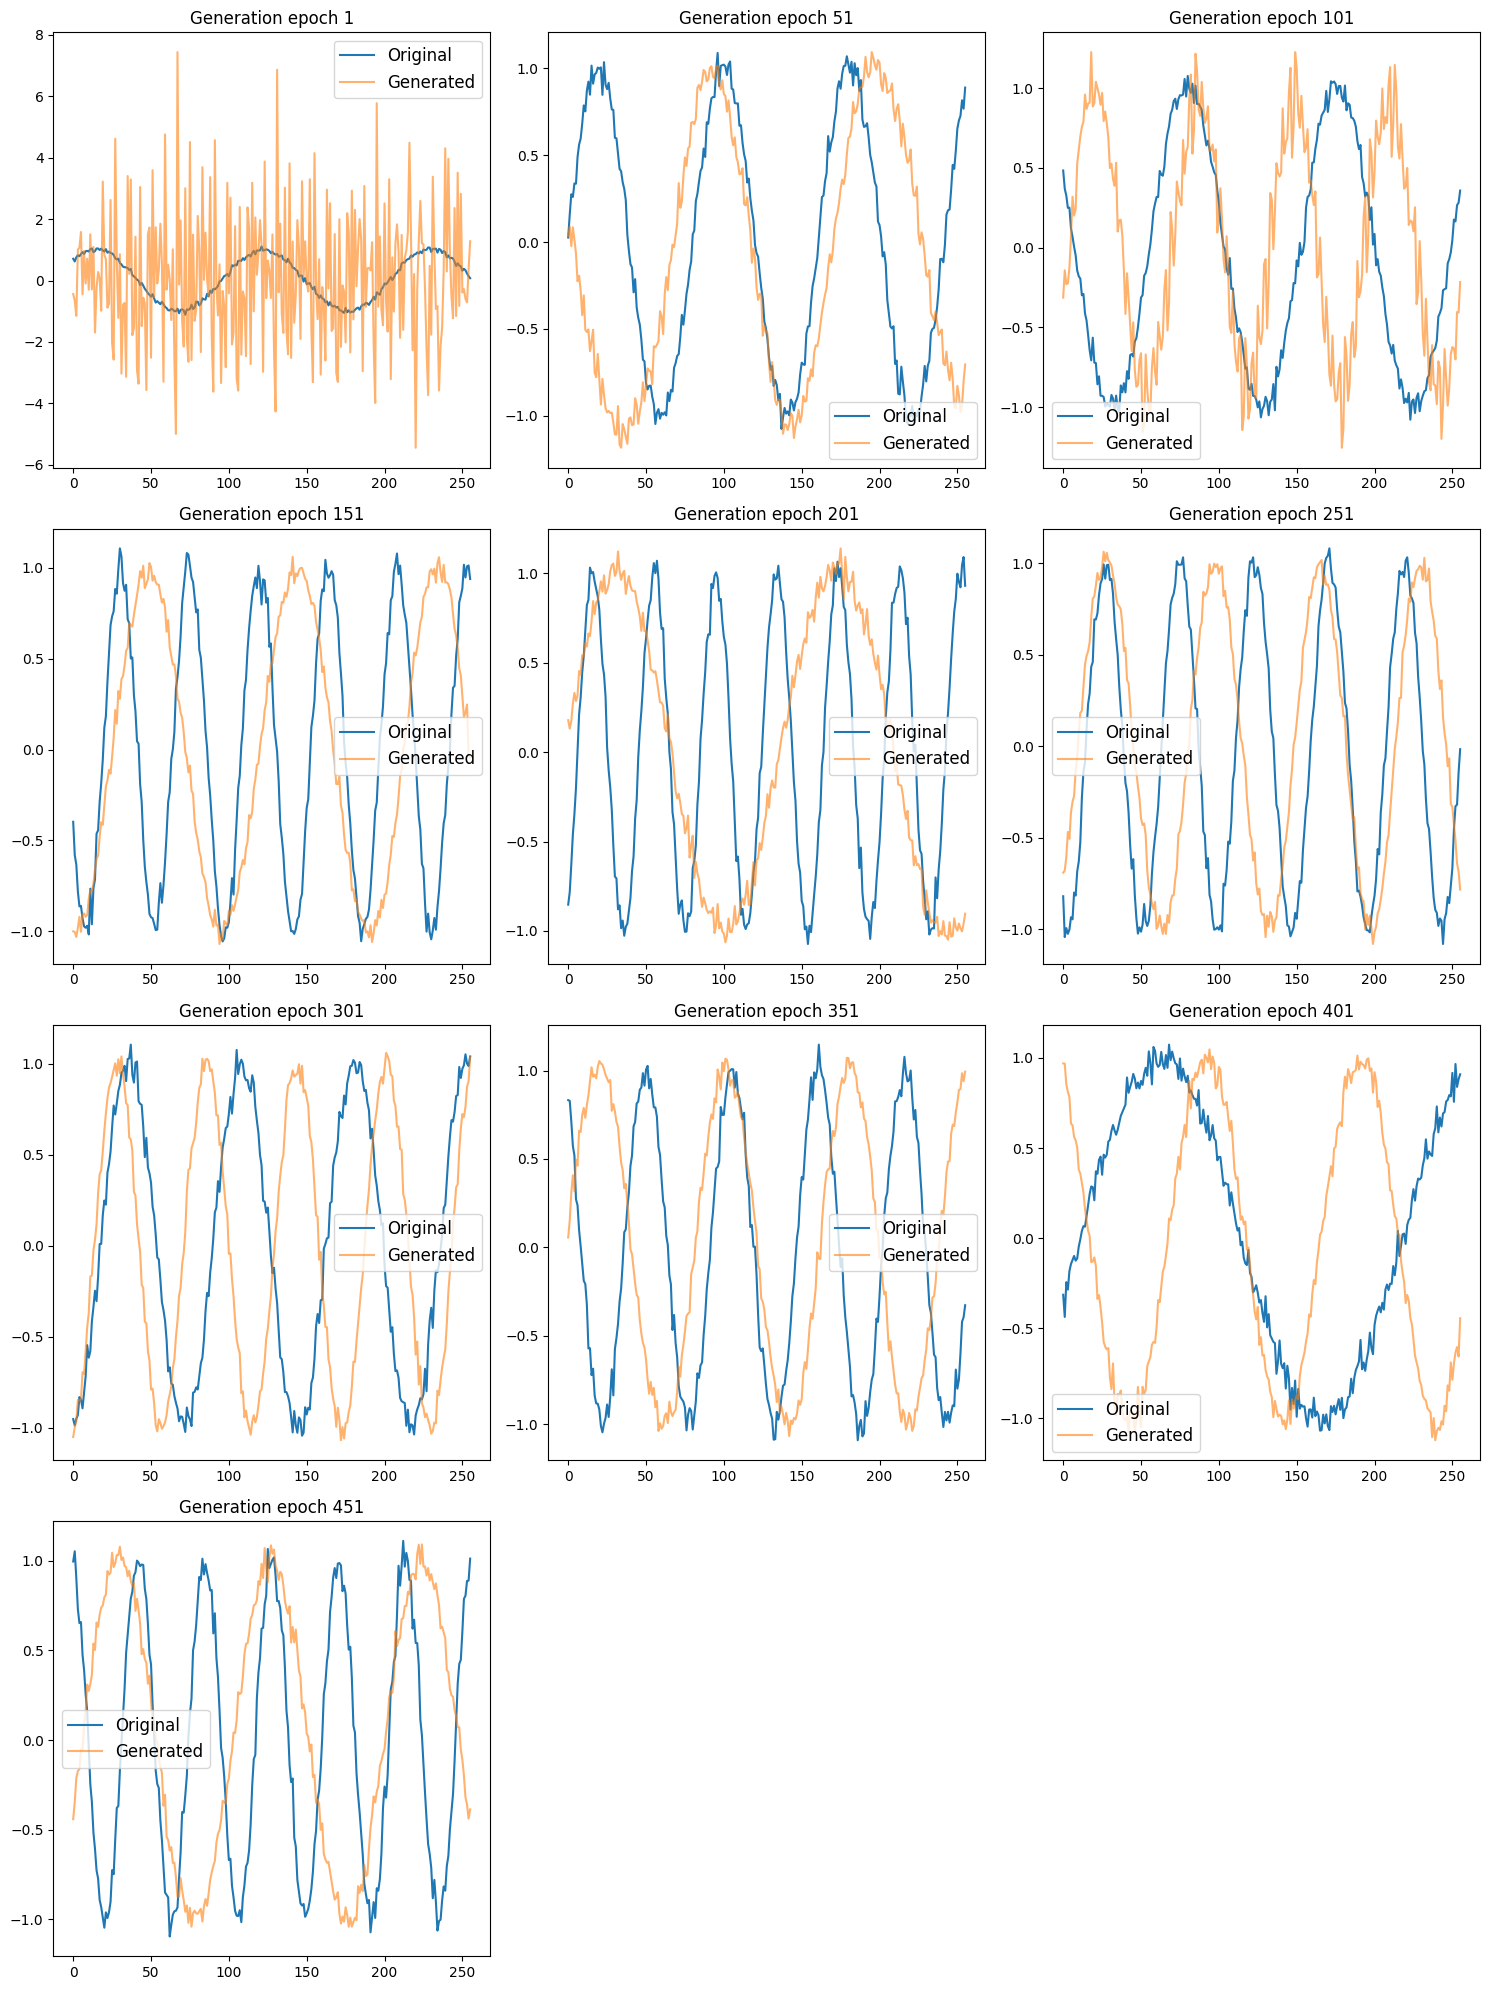

In [42]:
columns = 3
rows = math.ceil(len(original_sinusoidal_over_epochs) / columns)

fig, axs = plt.subplots(rows, columns, figsize=(15, 5*rows))
axs = axs.flatten()

for i in range(len(original_sinusoidal_over_epochs)):
    axs[i].plot(np.arange(0, len(original_sinusoidal_over_epochs[i])), original_sinusoidal_over_epochs[i][:,0], label='Original')
    axs[i].plot(np.arange(0, len(generated_sinusoidal_over_epochs[i])), generated_sinusoidal_over_epochs[i][:,0], label='Generated', alpha=0.6)
    axs[i].set_title(f'Generation epoch {epochs_plot[i]+1}')
    axs[i].legend(prop={'size': 12})

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# Evaluating models

This section provides a detailed explanation of the evaluation process for different models, the computation of distances between latent vectors, and the calculation of performance metrics to assess model effectiveness.

### **1. Evaluating Models and Generating Latent Representations**

- **Test Dataset Preparation**:  
  A synthetic test dataset is created using the `SinDataset` class, loaded through a `DataLoader` for sequential access during evaluation.

- **Model Evaluation Mode**:  
  Each model (`BYOL`, `GAN`, `VAE`) is set to evaluation mode, ensuring consistent behavior by disabling dropout and batch normalization layers.

- **Generating Latent Vectors**:  
  The input data is processed and fed through the models to extract latent vectors:
  - `latent_byol` is derived from the `BYOL` model.
  - `latent_gan` is generated using the `GAN` model.
  - `latent_vae` is computed from the `VAE` model.

- **Storing Latent Vectors**:  
  The generated vectors are stored in a list (`latent_dataset`) for subsequent analysis, enabling a comparative evaluation of model outputs.

In [43]:
test_dataset = SinDataset(n_samples=cfg.n_samples_test, seq_size=cfg.seq_size)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [106]:
latent_dataset = []

print('Creating latent dataset')
byol.eval()
byol.net.eval()
byol.online_encoder.eval()
net_Sim.eval()
vae.eval()
with torch.no_grad():
    for i, (positive1, positive2, b, name) in enumerate(tqdm(test_dataloader)):
        #print(idx)
        positive1 = positive1.unsqueeze(-1).float().to(cfg.device)
        positive1 = positive1.permute(0, 2, 1)
        
        latent_byol, _ = byol(positive1, return_embedding=True)
        latent_gan = net_Sim.forward_once(positive1)
        latent_vae, _ = vae.encode(positive1)
        
        positive1 = positive1.permute(0, 2, 1).cpu().detach().numpy()
        
        latent_dataset.append([name, b, positive1, latent_byol, latent_gan, latent_vae])

Creating latent dataset


100%|██████████| 1000/1000 [00:15<00:00, 64.78it/s]


In [107]:
latent_dataset_vectors_byol = torch.stack([latent_dataset[i][3].squeeze(0) for i in range(len(latent_dataset))], dim=0)
latent_dataset_vectors_gan = torch.stack([latent_dataset[i][4].squeeze(0) for i in range(len(latent_dataset))], dim=0)
latent_dataset_vectors_vae = torch.stack([latent_dataset[i][5].squeeze(0) for i in range(len(latent_dataset))], dim=0)
print(latent_dataset_vectors_byol.shape)

torch.Size([1000, 256])


### **2. Computing Pairwise Distances and Ranking**

- **Initialization**:  
  Arrays (`y_true`, `y_pred_byol`, `y_pred_gan`, `y_pred_vae`, `y_pred_dtw`) are initialized to store true and predicted labels for each model.

- **Distance Computation**:
  - **Euclidean Distances**:  
    Euclidean distances are computed between latent vectors from different models to evaluate how well each model captures relationships within the data.
  
  - **Dynamic Time Warping (DTW) Distances**:  
    DTW distances are calculated for comparing time series data, accounting for shifts and variability in sequence alignment.

- **Ranking and Sorting Distances**:  
  Distances are sorted, and ranking labels are assigned based on the proximity of latent vectors. This ranking helps determine which model best represents the data's underlying structure.

In [110]:
with torch.no_grad():
    
    total_samples=0

    y_true = []
    y_pred_byol = []
    y_pred_vae = []
    y_pred_gan = []
    y_pred_dtw = []

    closest_b_byol = []
    closest_b_vae = []
    closest_b_gan = []
    closest_b_dtw = []
    
    for i, (positive1, positive2, b, name) in enumerate(tqdm(test_dataloader)):
        
        positive1 = positive1.unsqueeze(-1).float().to(cfg.device)
        positive2 = positive2.unsqueeze(-1).float().to(cfg.device)
        positive1 = positive1.permute(0, 2, 1)
        positive2 = positive2.permute(0, 2, 1)
        
        distances = []
        latent_original_byol, _ = byol(positive1, return_embedding=True)
        latent_original_gan = net_Sim.forward_once(positive1)
        latent_original_vae, _ = vae.encode(positive1)
        
        latent_dataset_vectors_byol_cpy = latent_dataset_vectors_byol.clone()
        latent_dataset_vectors_gan_cpy = latent_dataset_vectors_gan.clone()
        latent_dataset_vectors_vae_cpy = latent_dataset_vectors_vae.clone()
        latent_dataset_cpy = latent_dataset.copy()

        b_distances = []
        dtw_distances = []
        for j in range(len(latent_dataset_cpy)):
            name2, b2, sequence2, latent_byol2, latent_gan2, latent_vae2 = latent_dataset_cpy[j]
            #print(type(pair_sequence))
            #original_well_cpy = original_well.permute(0, 2, 1).cpu().numpy()
            pair_sequence_cpy = np.transpose(sequence2, (0, 2, 1))
            argument1 = positive1.squeeze(0).cpu()
            argument2 = torch.tensor(pair_sequence_cpy.squeeze(0)).cpu()
            dtw_distance_number = dtw_distance(argument1, argument2)
            if name != name2:
                dtw_distances.append([latent_dataset_cpy[j][0], dtw_distance_number, abs(b2.item()-b.item())])
                b_distances.append([latent_dataset_cpy[j][0], abs(b2-b)])
            
        euclidean_distance_byol = F.pairwise_distance(latent_original_byol, latent_dataset_vectors_byol_cpy, keepdim = True).cpu().numpy()
        euclidean_distance_gan = F.pairwise_distance(latent_original_gan, latent_dataset_vectors_gan_cpy, keepdim = True).cpu().numpy()
        euclidean_distance_vae = F.pairwise_distance(latent_original_vae, latent_dataset_vectors_vae_cpy, keepdim = True).cpu().numpy()

        byol_distances = [[latent_dataset_cpy[j][0], euclidean_distance_byol[j][0], abs(latent_dataset_cpy[j][1].item()-b.item())] for j in range(len(euclidean_distance_byol)) if latent_dataset_cpy[j][0]!=name]
        gan_distances = [[latent_dataset_cpy[j][0], euclidean_distance_gan[j][0], abs(latent_dataset_cpy[j][1].item()-b.item())] for j in range(len(euclidean_distance_gan)) if latent_dataset_cpy[j][0]!=name]
        vae_distances = [[latent_dataset_cpy[j][0], euclidean_distance_vae[j][0], abs(latent_dataset_cpy[j][1].item()-b.item())] for j in range(len(euclidean_distance_vae)) if latent_dataset_cpy[j][0]!=name]
        
        positive1 = positive1.cpu().numpy()
        byol_distances = sorted(byol_distances, reverse=False, key=lambda x: x[1])
        gan_distances = sorted(gan_distances, reverse=False, key=lambda x: x[1])
        vae_distances = sorted(vae_distances, reverse=False, key=lambda x: x[1])
        dtw_distances = sorted(dtw_distances, reverse=False, key=lambda x: x[1])
        b_distances = sorted(b_distances, reverse=False, key=lambda x: x[1])

        closest_b_byol.append(byol_distances[0][2])
        closest_b_gan.append(gan_distances[0][2])
        closest_b_vae.append(vae_distances[0][2])
        closest_b_dtw.append(dtw_distances[0][2])
        
        ranking_dtw = [int(k[0][0]) for k in dtw_distances]
        ranking_byol = [int(k[0][0]) for k in byol_distances]
        ranking_gan = [int(k[0][0]) for k in gan_distances]
        ranking_vae = [int(k[0][0]) for k in vae_distances]
        ranking_label = [int(k[0][0]) for k in b_distances]

        y_true.append(ranking_label)
        y_pred_byol.append(ranking_byol)
        y_pred_gan.append(ranking_gan)
        y_pred_vae.append(ranking_vae)
        y_pred_dtw.append(ranking_dtw)

100%|██████████| 1000/1000 [28:21<00:00,  1.70s/it]


In [111]:
mean_freq_diff_to_closest_byol = np.mean(closest_b_byol)
mean_freq_diff_to_closest_gan = np.mean(closest_b_gan)
mean_freq_diff_to_closest_vae = np.mean(closest_b_vae)
mean_freq_diff_to_closest_dtw = np.mean(closest_b_dtw)

std_freq_diff_to_closest_byol = np.std(closest_b_byol)
std_freq_diff_to_closest_gan = np.std(closest_b_gan)
std_freq_diff_to_closest_vae = np.std(closest_b_vae)
std_freq_diff_to_closest_dtw = np.std(closest_b_dtw)

print('Average and standard deviation of the absolute frequency difference between each query and its closest sequence. LOWER IS BETTER!')

print(f'BYOL: {mean_freq_diff_to_closest_byol:.4f}({std_freq_diff_to_closest_byol:.4f})')
print(f'WELLGT: {mean_freq_diff_to_closest_gan:.4f}({std_freq_diff_to_closest_gan:.4f})')
print(f'VAE: {mean_freq_diff_to_closest_vae:.4f}({std_freq_diff_to_closest_vae:.4f})')
print(f'DTW: {mean_freq_diff_to_closest_dtw:.4f}({std_freq_diff_to_closest_dtw:.4f})')

Average and standard deviation of the absolute frequency difference between each query and its closest sequence. LOWER IS BETTER!
BYOL: 0.0018(0.0014)
WELLGT: 0.0007(0.0012)
VAE: 0.0018(0.0099)
DTW: 0.0019(0.0016)


### **3. Performance Metrics Calculation**

- **Metric Initialization**:  
  A dictionary (`metrics`) is created to store various performance metrics for each model, including `Mean Average Precision (MAP)` and `Mean Reciprocal Rank (MRR)`.

- **Calculating MAP and MRR**:
  - **Mean Reciprocal Rank (MRR)**:  
    Measures the position of the first relevant result among the top K results. A higher MRR indicates that relevant items are ranked closer to the top.
  
  - **Mean Average Precision (MAP)**:  
    Evaluates the precision of relevant items within the top K results, averaging precision scores across multiple queries to provide an overall measure of ranking quality.


- **Model Comparisons**:  
  Metrics are calculated for each model (`BYOL`, `GAN`, `VAE`, and `DTW`) across different values of K, allowing for a comprehensive comparison of their performance.

In [112]:
def mean_reciprocal_rank_at_k(y_true, y_pred, k):
    reciprocal_ranks = []
    for true, pred in zip(y_true, y_pred):
        found = False
        for i, p in enumerate(pred[:k]):
            if p in true[:k]:
                reciprocal_ranks.append(1 / (i + 1))
                found = True
                break
        if not found:
            reciprocal_ranks.append(0)
    return np.mean(reciprocal_ranks)

def average_precision_at_k(y_true, y_pred, k):
    precisions = []
    relevant_items = 0
    for i, pred in enumerate(y_pred[:k]):
        if pred in y_true[:k]:
            relevant_items += 1
            precisions.append(relevant_items / (i + 1))
    return np.mean(precisions) if precisions else 0

def mean_average_precision_at_k(y_true, y_pred, k):
    return np.mean([average_precision_at_k(true, pred, k) for true, pred in zip(y_true, y_pred)])

In [113]:
metrics = dict()
metrics['MAP@3'] = dict()
metrics['MAP@5'] = dict()
metrics['MAP@10'] = dict()
metrics['MRR@5'] = dict()
metrics['MRR@10'] = dict()

metrics['MAP@3']['BYOL'] = mean_average_precision_at_k(y_true, y_pred_byol, k=3)
metrics['MAP@3']['WellGT'] = mean_average_precision_at_k(y_true, y_pred_gan, k=3)
metrics['MAP@3']['VAE'] = mean_average_precision_at_k(y_true, y_pred_vae, k=3)
metrics['MAP@3']['DTW'] = mean_average_precision_at_k(y_true, y_pred_dtw, k=3)

metrics['MAP@5']['BYOL'] = mean_average_precision_at_k(y_true, y_pred_byol, k=5)
metrics['MAP@5']['WellGT'] = mean_average_precision_at_k(y_true, y_pred_gan, k=5)
metrics['MAP@5']['VAE'] = mean_average_precision_at_k(y_true, y_pred_vae, k=5)
metrics['MAP@5']['DTW'] = mean_average_precision_at_k(y_true, y_pred_dtw, k=5)

metrics['MAP@10']['BYOL'] = mean_average_precision_at_k(y_true, y_pred_byol, k=10)
metrics['MAP@10']['WellGT'] = mean_average_precision_at_k(y_true, y_pred_gan, k=10)
metrics['MAP@10']['VAE'] = mean_average_precision_at_k(y_true, y_pred_vae, k=10)
metrics['MAP@10']['DTW'] = mean_average_precision_at_k(y_true, y_pred_dtw, k=10)

metrics['MRR@5']['BYOL'] = mean_reciprocal_rank_at_k(y_true, y_pred_byol, k=5)
metrics['MRR@5']['WellGT'] = mean_reciprocal_rank_at_k(y_true, y_pred_gan, k=5)
metrics['MRR@5']['VAE'] = mean_reciprocal_rank_at_k(y_true, y_pred_vae, k=5)
metrics['MRR@5']['DTW'] = mean_reciprocal_rank_at_k(y_true, y_pred_dtw, k=5)

metrics['MRR@10']['BYOL'] = mean_reciprocal_rank_at_k(y_true, y_pred_byol, k=10)
metrics['MRR@10']['WellGT'] = mean_reciprocal_rank_at_k(y_true, y_pred_gan, k=10)
metrics['MRR@10']['VAE'] = mean_reciprocal_rank_at_k(y_true, y_pred_vae, k=10)
metrics['MRR@10']['DTW'] = mean_reciprocal_rank_at_k(y_true, y_pred_dtw, k=10)

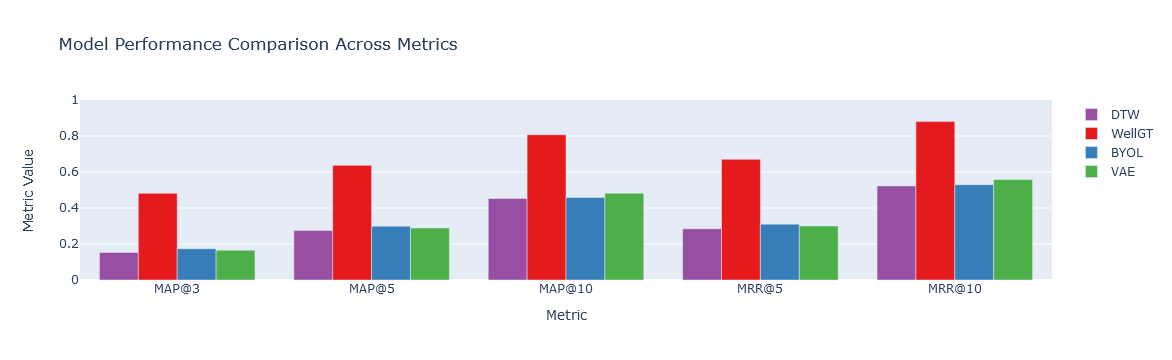

In [114]:
# Define the colors you want for each model
model_colors = {
    'WellGT': '#e41a1c',
    'BYOL': '#377eb8',
    'VAE': '#4daf4a',
    'DTW': '#984ea3'
}

fig = go.Figure()

models = set(model for metric in metrics.values() for model in metric)
for model in models:
    fig.add_trace(go.Bar(
        x=list(metrics.keys()),
        y=[metrics[metric].get(model, None) for metric in metrics],
        name=model,
        marker_color=model_colors.get(model, 'gray')  # Default color if model not in dictionary
    ))

fig.update_layout(
    title='Model Performance Comparison Across Metrics',
    xaxis_title='Metric',
    yaxis_title='Metric Value',
    barmode='group'
)

fig.update_yaxes(range=[0, 1])

# Show figure
fig.show()

### **Summary**

This combined evaluation pipeline assesses model effectiveness by comparing their ability to generate meaningful latent representations, compute accurate distances, and rank sequences correctly. The inclusion of both Euclidean and DTW distances ensures a thorough evaluation, particularly for time series data, while MAP and MRR metrics provide a clear measure of ranking performance.

**Advantages of each model**

- **BYOL**: Byol is an advanced model with fast training, with 6 or 7 seconds per epoch, but does not seem to be able to efficiently identify the similar sequences in the long run.
- **DTW**: DTW has the advantage of not needing the training step. However, it lacks the ability to be robust to the jitter noise as it is used in the experiment. Another disadvantage is that it takes too long in the inference stage.
- **WellGT(GAN)**: Our model takes longer to train, with an average of 30 seconds per epoch, since it has 4 models to train at the same time. However, its results are better than all of the rest. It is the best option when training time is not a problem.
- **VAE**: It is the best option in terms of training time, with an average of 3 seconds per epoch. Its above average results show that it is not only fast but good enough to be used in most tasks.